# MLP on Simulated ORFs  
Start with ORF_MLP_118 which had the simulator bug fix.  
Evaluate MLP that is wide and deep.  
Train on copious simulated data.  
Use uniform but realistic RNA lengths.  

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-16 07:51:42 EDT


In [2]:
PC_TRAINS=1000
NC_TRAINS=1000
PC_TESTS=1000
NC_TESTS=1000   
RNA_LEN=1000  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.30
EPOCHS=10 # 200
SPLITS=3
FOLDS=1   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-16 07:51:42.625793: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import Collection_Generator, Transcript_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.RNA_gen import Collection_Generator, Transcript_Oracle
        from SimTools.KmerTools import KmerTools
BESTMODELPATH=DATAPATH+"BestModel"  # saved on cloud instance and lost after logout
LASTMODELPATH=DATAPATH+"LastModel"  # saved on Google Drive but requires login

CoLab not working. On my PC, use relative paths.


## Data Load


In [5]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")
pc_sim=None
nc_sim=None

2021-08-16 07:51:43 EDT
Generated 2000 PC seqs
Generated 2000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequence characteristics:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 1000.0
Average ORF length: 674.8335
NC seqs
Average RNA length: 1000.0
Average ORF length: 180.3675
2021-08-16 07:51:43 EDT


## Data Prep

In [7]:
def combine_pos_and_neg(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    return X,y
Xseq,y=combine_pos_and_neg(pc_all,nc_all)
print("The first few shuffled labels:")
print(y[:30])
pc_all=None
nc_all=None
show_time()

The first few shuffled labels:
[1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0]
2021-08-16 07:51:44 EDT


In [8]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    collection = []
    debug = 0
    for seq in seqs:
        counts = tool.make_dict_upto_K(max_K)
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
        if (debug<3):
            print(fdict)
            debug += 1;
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print("First few K-mer frequency matrices:")
print(Xfrq[:3])
Xseq = None
show_time()

{'A': 0.246, 'C': 0.252, 'G': 0.243, 'T': 0.259, 'AA': 0.05905905905905906, 'AC': 0.05905905905905906, 'AG': 0.06106106106106106, 'AT': 0.06706706706706707, 'CA': 0.06306306306306306, 'CC': 0.06606606606606606, 'CG': 0.05905905905905906, 'CT': 0.06406406406406406, 'GA': 0.06006006006006006, 'GC': 0.06006006006006006, 'GG': 0.06506506506506507, 'GT': 0.05805805805805806, 'TA': 0.06306306306306306, 'TC': 0.06706706706706707, 'TG': 0.05805805805805806, 'TT': 0.07007007007007007, 'AAA': 0.012024048096192385, 'AAC': 0.018036072144288578, 'AAG': 0.014028056112224449, 'AAT': 0.01503006012024048, 'ACA': 0.014028056112224449, 'ACC': 0.01603206412825651, 'ACG': 0.01002004008016032, 'ACT': 0.01903807615230461, 'AGA': 0.01903807615230461, 'AGC': 0.01903807615230461, 'AGG': 0.011022044088176353, 'AGT': 0.012024048096192385, 'ATA': 0.01503006012024048, 'ATC': 0.017034068136272545, 'ATG': 0.01903807615230461, 'ATT': 0.01503006012024048, 'CAA': 0.017034068136272545, 'CAC': 0.011022044088176353, 'CAG':

In [9]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 2000 = 2000
Reserved test set size= 2000 = 2000
2021-08-16 07:51:44 EDT


## Neural network

In [10]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10880     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)        

2021-08-16 07:51:44.852936: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 07:51:44.912759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-16 07:51:44.915381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-16 07:51:44.915513: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 07:51:44.920749: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-16 07:51:44.920817: I tensorflow/stream_executor

In [11]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    # No need to shuffle here assuming data was shuffled above.
    splitter = KFold(n_splits=SPLITS,shuffle=False) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-16 07:54:35 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/10
42/42 [==============================] - 1s 4ms/step - loss: 0.7327 - accuracy: 0.4829 - val_loss: 0.6924 - val_accuracy: 0.5217
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 2/10
42/42 [==============================] - 0s 2ms/step - loss: 0.7169 - accuracy: 0.5132 - val_loss: 0.6959 - val_accuracy: 0.5217
Epoch 3/10
42/42 [==============================] - 0s 1ms/step - loss: 0.7269 - accuracy: 0.5092 - val_loss: 0.6922 - val_accuracy: 0.5217
Epoch 4/10
42/42 [==============================] - 0s 2ms/step - loss: 0.7096 - accuracy: 0.5390 - val_loss: 0.6968 - val_accuracy: 0.5217
Epoch 5/10
42/42 [==============================] - 0s 1ms/step - loss: 0.7084 - accuracy: 0.5156 - val_loss: 0.6932 - val_accuracy: 0.4783
Epoch 6/10
42/42 [==============================] - 0s 2ms/step - loss: 0.7042 - accuracy: 0.4950 - val_loss: 0.6925 - val_accuracy: 0.5217
Epoch 7/10
42/42 [==================

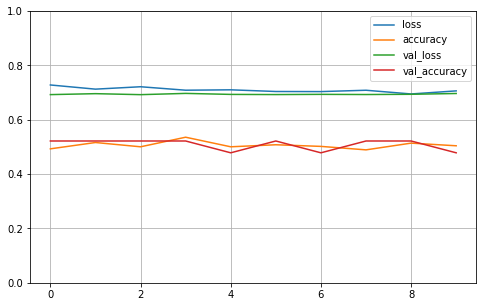

In [17]:
show_time()
last_model = do_cross_validation(X_train,y_train)
best_model = load_model(BESTMODELPATH)

In [18]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
2021-08-16 07:54:58 EDT


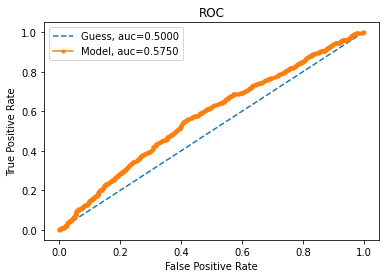

AUC: 57.50%
accuracy: 51.60%
2021-08-16 07:54:59 EDT


In [19]:
print("Accuracy on training data.")
show_time()
show_test_AUC(best_model,X_train,y_train)
show_test_accuracy(best_model,X_train,y_train)
show_time()

Accuracy on test data.
2021-08-16 07:55:01 EDT


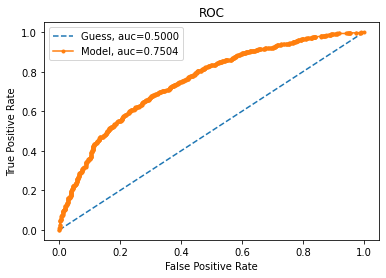

AUC: 75.04%
accuracy: 51.60%
2021-08-16 07:55:01 EDT


In [20]:
print("Accuracy on test data.")
show_time()
show_test_AUC(last_model,X_test,y_test)
show_test_accuracy(last_model,X_test,y_test)
show_time()